In [35]:
import pandas as pd
deplay_week = pd.read_csv('../data/raw/deplay_week_treated.csv')    

deplay_week.drop(['Unnamed: 0', 'Unnamed: 15', 'Unnamed: 17'], axis=1, inplace=True)
deplay_week['week'] = deplay_week['week'].str.replace('Week', '')
for column in deplay_week.columns:
    if deplay_week[column].dtype == 'object':
        deplay_week[column] = deplay_week[column].str.replace('€', '')
# drop this columns: 'Sales BE', 'Sales NL', 'Revenue BE', 'Revenue NL'
deplay_week.drop(['Sales BE', 'Sales NL', 'Revenue BE', 'Revenue NL'], axis=1, inplace=True)
# drop this columns Sales België	Sales Nederland
deplay_week.drop(['Sales België', 'Sales Nederland'], axis=1, inplace=True)
deplay_week['Conversion %'] = deplay_week['Conversion %'].str.replace('%', '')
# remove % sign from these columns Profit Margin	ROI
deplay_week['Profit Margin'] = deplay_week['Profit Margin'].str.replace('%', '')
deplay_week['ROI'] = deplay_week['ROI'].str.replace('%', '')
columns_to_convert = [
    'Sale price incl. VAT (Value Added Tax)', 'Sale price excl. VAT', 
    'Purchase price per piece', 'Sales', 'Revenue excl. VAT', 
    'Customer visits', 'Conversion %', 'Bol Costs', 'Shipping costs  BE', 'Shipping costs  NL', 
    'Total gross profit', 'Gross profit per piece', 'Saleable returns', 
    'Unsaleable returns', 'exchange items', 'Total returns', 
    'Total return costs', 'Total SP costs', 'Net profit', 
    'Net profit per peace', 'Profit Margin', 'ROI'
]

# Convert columns to float after cleaning the strings
for column in columns_to_convert:
    if deplay_week[column].dtype == 'object':  # Check if column contains strings
        deplay_week[column] = deplay_week[column].str.replace(',', '').str.replace('- ', '-').str.strip()
    deplay_week[column] = deplay_week[column].astype(float)

deplay_week['shipping_costs'] = deplay_week['Shipping costs  BE'] + deplay_week['Shipping costs  NL']
deplay_week.drop(['Shipping costs  BE', 'Shipping costs  NL'], axis=1, inplace=True)

deplay_week.drop_duplicates(inplace=True)
cleaned_data = deplay_week.drop(columns=[ 'exchange items']).fillna(0)
cleaned_data['week'] = cleaned_data['week'].astype(int)
cleaned_data.dropna(inplace=True)

In [36]:
# show all columns
pd.set_option('display.max_columns', None)
cleaned_data.head()

,Product,week,Sale price incl. VAT (Value Added Tax),Sale price excl. VAT,Purchase price per piece,Sales,Revenue excl. VAT,Customer visits,Conversion %,Bol Costs,Total gross profit,Gross profit per piece,Saleable returns,Unsaleable returns,Total returns,Total return costs,Total SP costs,Net profit,Net profit per peace,Profit Margin,ROI,shipping_costs
0,Tablet PRO Blauw,1,180.00,148.76,85.23,30.0,4462.74,251.0,11.95,359.70,1350.24,45.01,0.0,9.0,9.0,791.01,0.0,559.23,18.64,12.53,21.87,195.90
1,Tablet PRO Blauw,2,184.00,152.07,85.23,25.0,3801.74,949.0,2.63,304.76,1209.33,48.37,0.0,10.0,10.0,878.90,0.0,330.43,13.22,8.69,15.51,156.90
2,Tablet PRO Blauw,3,184.00,152.07,85.23,20.0,3041.40,975.0,2.05,243.80,961.90,48.09,0.0,5.0,5.0,439.45,0.0,522.45,26.12,17.18,30.65,131.10
3,Tablet PRO Blauw,4,184.00,152.07,85.23,36.0,5474.49,796.0,4.52,438.85,1752.41,48.68,0.0,7.0,7.0,615.23,0.0,1137.18,31.59,20.77,37.06,214.95
4,Tablet PRO Blauw,5,188.25,155.58,85.23,20.0,3111.61,672.0,2.98,248.05,1040.76,52.04,0.0,5.0,5.0,439.45,0.0,601.31,30.07,19.32,35.28,118.20


In [42]:
#OUT OF STOCK CLASS
#Detects out of stock days and pedicts probability of out of stock for inference

from matplotlib.font_manager import json_dump
import numpy as np
from scipy.optimize import curve_fit

import json

class out_of_stock_zeroes():
    def __init__(self,
                 sales_array: np.array,

                 calculate_oos_array: bool =True):
        self.sales_array = sales_array

        #When do the sales start. A series of zeros at the beginning only means that the product is not yet available and should not be considered as an indicator of out of stock
        start = np.argmax(sales_array != 0)
        sales_array_without_start = sales_array[start:].copy()
        sales_array_start = sales_array[:start].copy()
        
        
        self.counter = self._build_zero_seq_counter(sales_array_without_start)
        
        self.zeroes_seq = self.rle(self.counter,0)

        
        #If we want to calculate an array of same size than self.sales_array with a boolean flag if out of stock
        if calculate_oos_array:
            #First we calculate the minimal sequence length from which we consider that those zeros are due to out of stocl
            self.divisor = self._log_divisor(sales_array) #The higher the mean value of sales, the lower the zeros sequence length needs to be to be considered oos
            self.out_of_stock_min_length = self._get_min_length_oos(self.zeroes_seq,self.divisor)
            
            #Based on the information of what is the out_of_stock_min_length, we can now calculate the oos flag array
            self.zeroes_seq_sales = self.rle(sales_array_without_start,0)
            self.oos_coordinates = self._build_oos_coordinates(start,self.zeroes_seq_sales,self.out_of_stock_min_length)
            self.oos_array = self._build_oos_array(sales_array.shape[0],self.oos_coordinates)
            self.oos_new_array = None
        
        
        # We calculate what is the minimal sequence length of consecutive zeros starting from which out of stock is likely for prediction
        # We use a divisor of 1 in this case as it resulted in better CV
        self.out_of_stock_min_length_for_oos_pred = self._get_min_length_oos(self.zeroes_seq,1)
        
    def _build_zero_seq_counter(self,sales_array):
        '''
        From an array sales_array, builds an array counting the zeros sequence length
        Such as sales_array = [0,1,0,0,1,0,1,0,0,0,0,1]
        Would result in counter = [2,1,0,1]
        '''
        mask = sales_array!=0
        sales_array = sales_array[np.argmax(mask):]
        self.sales_array_without_begin = sales_array
        l = sales_array==0
        counter = np.diff(np.where(np.concatenate(([l[0]],
                                         l[:-1] != l[1:],
                                         [True])))[0])[::2]
        counter = np.bincount(counter)
        counter = counter[1:]
        return counter
        
    def rle(self, a, value=None):
        """
        From an array, calculates the sequences of same value length and position
        Such as a = [10,5,4,0,0,0,0,1,0,0,0,1] and value = 0
        Would result in [(4,3),(3,7)], each element of the array being (length of sequence, position in initial array)
        """
        ia = np.asarray(a)                # force numpy
        n = len(ia)
        if n==0:
            return np.array([[],[]])
        y = np.array(ia[1:] != ia[:-1])     # pairwise unequal (string safe)
        i = np.append(np.where(y), n - 1)   # must include last element posi
        z = np.diff(np.append(-1, i))       # run lengths
        p = np.cumsum(np.append(0, z))[:-1] # positions

        if value is None:
            return np.concatenate([z.reshape(-1,1),p.reshape(-1,1),ia[i].reshape(-1,1)],axis=1)
        else:
            mask = ia[i] == value
            return np.concatenate([z[mask].reshape(-1,1),p[mask].reshape(-1,1)],axis=1)
        
    def _log_divisor(self,a):
        s = a[a>0]
        if s.shape[0]==0:
            return 1e-3
        mean_no_zeros = a[a>0].mean()
        return np.log1p(mean_no_zeros)+1e-3
    
    def _get_min_length_oos(self,zeroes_seq,divisor=1):
        """
        Idea is to look at the zeros sequence length such as [5,4,3,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1]
        When the first zero sequence in the zero sequence array (a bit confusing here sorry) is longer than what came before, then we consider that position to be the minimum sequence length to be oos
        In this example, the first zero sequence of the zero sequence array is in the 4th position but has size 1
        The second sequence is in 6 position but has length 7. So in case divisor=1, the minimal size for oos is 6 => any sequence of zeros in the sales array with a length greater than 6 is to be considered oos
        """
        if zeroes_seq.shape[1]==0:
            return self.sales_array.shape[0]
        zeroes_seq_tmp = zeroes_seq.copy()
        zeroes_seq[:,0] = zeroes_seq[:,0] + zeroes_seq[:,1] + 1
        zeroes_seq_tmp[:,1] = zeroes_seq_tmp[:,1]/divisor
        filtered_seq = zeroes_seq[zeroes_seq_tmp[:,0]>zeroes_seq_tmp[:,1]]
        if filtered_seq.shape[0]==0:
            return self.sales_array.shape[0]
        return filtered_seq[0][1]+1
    
    def _build_oos_coordinates(self,start,zeroes_seq_sales,out_of_stock_min_length):
        oos_coordinates = zeroes_seq_sales[zeroes_seq_sales[:,0]>=out_of_stock_min_length].copy()
        oos_coordinates[:,1] = oos_coordinates[:,1] + start
        oos_coordinates = np.concatenate([[[start,0]],oos_coordinates],axis=0)
        return oos_coordinates
        
    def _build_oos_array(self,length,oos_coordinates):
        a = np.zeros(length)
        for coord in oos_coordinates:
            a[coord[1]:coord[1]+coord[0]] = 1
        return a
    
    
    def curve_func(self,x,a):
        return 1/(1+a*np.sqrt(x))

    
    def build_oos_prob_array(self,
                             zeros_before: int ,
                             alpha: float =2) -> np.array:
        """
        :param zeros_before: Zero sequences before the inference
        :param alpha: Sensitivity parameter, higher values result in lower oos probability
        
        This function calculates an array of size 28 that will serve as multiplier array to the inference.
        Idea is to transform any element that we consider oos to zero in the inference
        For example if just before the inference, a product had a sequence of 50 zeros while usually it is never zero, we create an array to transform the inference to zero.
        
        Also for each sales_array sequence, we fit a simple curve (1/(1+a*np.sqrt(x))) to give us the probability that a sequence will have a size N given how long it is already (n_zeros_before) and how long the oos sequences were in the history of this sales array
        For example if a sales_array has oos sequences such as [0,0,0,0,0,4,3,2,0,1] meaning that the shortest oos sequence has size 6 and occured 4 times in the past
        Then we fit x=[1,2,3,4,5] y=[4,3,2,0,1]/sum([4,3,2,0,1]) to get the parameter a
        So now if we have a sequence of zeroes before of size 7, we can plug calculate the probability of oos based on the curve that we just fit
        
        The higher the alpha, the lower the probability of oos sequence
        """
        counter_cumsum = np.cumsum(self.counter)
        #How many times oos sequences occured
        oos_occurences = counter_cumsum[-1] - counter_cumsum[self.out_of_stock_min_length_for_oos_pred-1]
        
        #Min zeroes sequence after which 1/alpha% chances of a oos
        alpha_oos_zeros_seq_size_prob = np.argmax(counter_cumsum>counter_cumsum[-1]-alpha*oos_occurences)
       
    #if zeros before inferior to half_oos_zeros_seq_size_prob then not a oos sequence
        if zeros_before<alpha_oos_zeros_seq_size_prob:
            return np.ones(28)
        
        #Inverse cumsum of zeroes occurences
        inverse_cumsum = counter_cumsum[-1] - counter_cumsum[alpha_oos_zeros_seq_size_prob:]
        
        #Get indices of oos occurences
        x_oos_occurences = np.concatenate([np.array([0]),np.where(inverse_cumsum[1:] != inverse_cumsum[:-1])[0]+1])
        y_oos_occurences = inverse_cumsum[x_oos_occurences]
        y_oos_occurences = y_oos_occurences / y_oos_occurences[0]
        if y_oos_occurences.shape[0]<=2:
            x_oos_occurences = np.insert(x_oos_occurences, -1, x_oos_occurences[-1]-0.1)
            y_oos_occurences = np.insert(y_oos_occurences, -1, 1e-5)
        
        #Fit curve
        a,cor = curve_fit(self.curve_func, x_oos_occurences, y_oos_occurences,p0=[1],bounds=([0],[np.inf]))
        
        #Calculate probs with zeroes before
        x_prob = np.array([zeros_before - alpha_oos_zeros_seq_size_prob + i for i in range(29)])
        y_prob = self.curve_func(x_prob,a[0])
        y_prob = y_prob/y_prob[0]
        
        #Arbitrary values for oos calculation optimized with CV
        oos_new_array = np.where(y_prob>0.4,
                                 np.where(y_prob>0.7,0,1-y_prob),
                                 1)
        return oos_new_array[1:]
        
            
        

In [43]:
single_product_data = cleaned_data[cleaned_data['Product'] == 'Tablet PRO Blauw'].copy()


In [44]:
# grouby Product and count how many zeros each product has
cleaned_data.groupby('Product')['Sales'].apply(lambda x: (x==0).sum()).sort_values(ascending=False)



Product
Tablet SMART Rood      52
Tablet SMART Blauw     52
Tablet PRO Blauw       38
Tablet PRO Rood        35
Slaapprojector         33
Muziek Drum            32
KidsWatch Paars        28
Sterrenmobiel Blauw    25
Tablet Blauw           25
Sterrenmobiel Roze     25
Xylofoon               25
Activiteiten Kubus     25
Piano MAT              25
Muziek Piano           25
KidsWatch Roze         25
KidsWatch Blauw        25
BabyGym                25
KidsWatch Zwart        24
Tablet Rood            24
0                       1
Name: Sales, dtype: int64

18:07:52 - cmdstanpy - INFO - Chain [1] start processing


single product (52,)
oss flags (52,)


18:07:52 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 5.9817542562018104
Potential Out-of-Stock Weeks: []


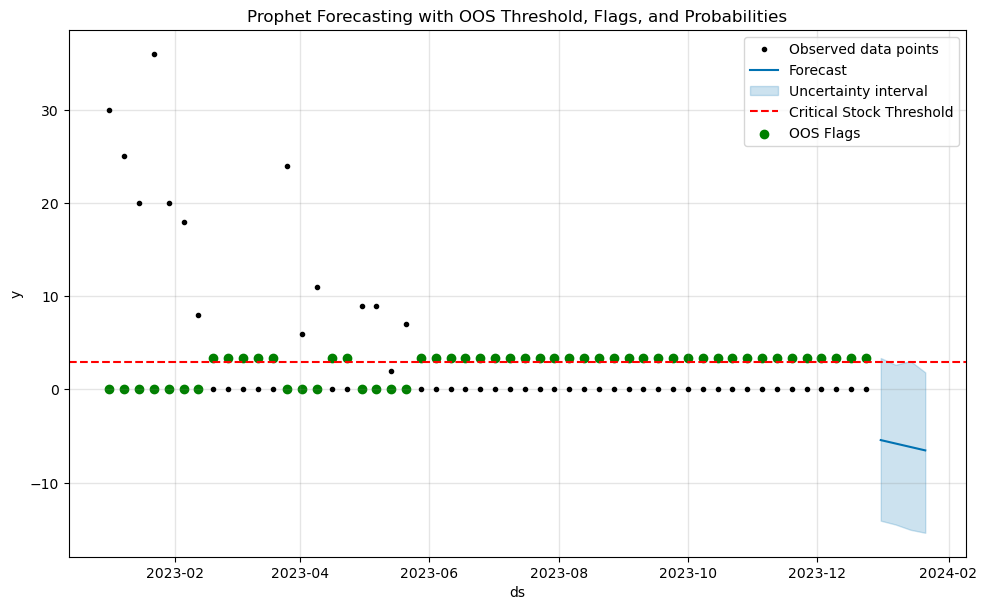

COMBINED ALERT: Potential Out-of-Stock for weeks [8, 9, 10, 11, 12, 16, 17, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]


In [45]:
# revised apporach

from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# 1. Prepare data for Prophet model
df = cleaned_data.copy()
df['ds'] = df['week'].apply(lambda x: datetime.strptime("2023-01-01", "%Y-%m-%d") + timedelta(weeks=x-1))

# log transfomation
#df['Log_Sales'] = np.log1p(df['Sales'])

# 2. Initialize and fit the Prophet model for single product
single_product_data = df[df['Product'] == 'Tablet PRO Blauw'].copy()

# Initialize oos class
single_product = single_product_data['Sales'].values
print('single product', single_product.shape)
oos_class = out_of_stock_zeroes(single_product)
oos_flags = oos_class.oos_array  # This will give us the OOS flags
print('oss flags', oos_flags.shape)
#mask = single_product != 0
#zeros_before = np.argmax(mask[::-1])
#oos_prob_array = oos_class.build_oos_prob_array(zeros_before)

# 3. Merge OOS flags and OOS probs with your existing dataframe
single_product_data['OOS_Flag'] = oos_flags
#single_product_data['OOS_Prob'] = oos_prob_array
prophet_data = single_product_data[['ds', 'Sales']].rename(columns={'ds': 'ds', 'Sales': 'y'})


# Fit the model
prophet_model = Prophet(weekly_seasonality=True, yearly_seasonality=False, daily_seasonality=False)
#prophet_model.add_country_holidays(country_name='US')  # Add holidays
prophet_model.fit(prophet_data)

# 3. Make future dataframe
future = prophet_model.make_future_dataframe(periods=4, freq='W-SUN', include_history=False)

# 4. Forecast
forecast = prophet_model.predict(future)

#forecasted_sales = np.expm1(forecast['yhat'])

# 5. MAE Calculation
mae_prophet = mean_absolute_error(np.expm1(prophet_data['y'].iloc[-4:]), forecast['yhat'].iloc[-4:])
print(f"Mean Absolute Error (MAE): {mae_prophet}")

# 6. Establishing Stock Threshold using 75th percentile
critical_stock_threshold = prophet_data['y'].quantile(0.75)

# 7. Identifying Potential OOS Weeks
future_df = pd.DataFrame({
    'week': range(max(df['week']) + 1, max(df['week']) + 1 + 4),
    'Predicted_Sales': forecast['yhat'][-4:].values
})
future_df['Potential_OOS'] = future_df['Predicted_Sales'] > critical_stock_threshold

#future_df['OOS_Prob'] = oos_prob_array[-len(future_df):]  # Use the last N values, where N is the number of future periods
#future_df['Adjusted_Predicted_Sales'] = future_df['Predicted_Sales'] * (1 - future_df['OOS_Prob'])


# 8. Extract potential OOS weeks
potential_oos_weeks = future_df[future_df['Potential_OOS']]['week'].tolist()
print(f"Potential Out-of-Stock Weeks: {potential_oos_weeks}")


# 9. Plotting: Add OOS flags to Prophet plot
fig = prophet_model.plot(forecast)
plt.axhline(y=critical_stock_threshold, color='r', linestyle='--', label='Critical Stock Threshold')
plt.scatter(single_product_data['ds'], single_product_data['OOS_Flag']*forecast['yhat_upper'].max(), color='g', label='OOS Flags')
#plt.scatter(single_product_data['ds'], single_product_data['OOS_Prob']*forecast['yhat_upper'].max(), color='b', label='Historical OOS Prob')
plt.title('Prophet Forecasting with OOS Threshold, Flags, and Probabilities')
plt.legend()
plt.show()

# 10. Combined Alert System for OOS

# List of weeks with potential OOS based on Prophet model
alert_prophet = future_df[future_df['Potential_OOS']]['week'].tolist()

# List of weeks with OOS flags based on historical data
alert_oos_flag = single_product_data[single_product_data['OOS_Flag'] == 1]['week'].tolist()

# List of weeks with high OOS probability based on your new prediction model
#alert_prob = single_product_data[single_product_data['OOS_Prob'] > 0.7]['week'].tolist()

# Combine all three alerts into a single set to eliminate duplicates
#combined_alert = set(alert_prophet + alert_oos_flag + alert_prob)
combined_alert = set(alert_prophet + alert_oos_flag)

# Generate the final combined alert
if len(combined_alert) > 0:
    print(f"COMBINED ALERT: Potential Out-of-Stock for weeks {sorted(list(combined_alert))}")
else:
    print("No Combined OOS Alert")

# Update this line to use 'Adjusted_Predicted_Sales'
#future_df['Adjusted_Potential_OOS'] = future_df['Adjusted_Predicted_Sales'] > critical_stock_threshold

# Generate a new list of weeks with potential OOS based on adjusted predictions
#alert_adjusted_prophet = future_df[future_df['Adjusted_Potential_OOS']]['week'].tolist()

# Update combined alert to include adjusted OOS predictions
#combined_alert = set(alert_prophet + alert_oos_flag + alert_prob + alert_adjusted_prophet)

# Generate the final combined alert
#if len(combined_alert) > 0:
    #print(f"UPDATED COMBINED ALERT: Potential Out-of-Stock for weeks {sorted(list(combined_alert))}")
#else:
#    print("No Updated Combined OOS Alert")






single_product_data shape (52,)
Sales array shape 28 days:  (24,)
Non-zero entries:  14
Consecutive zeros before last 28 days:  3


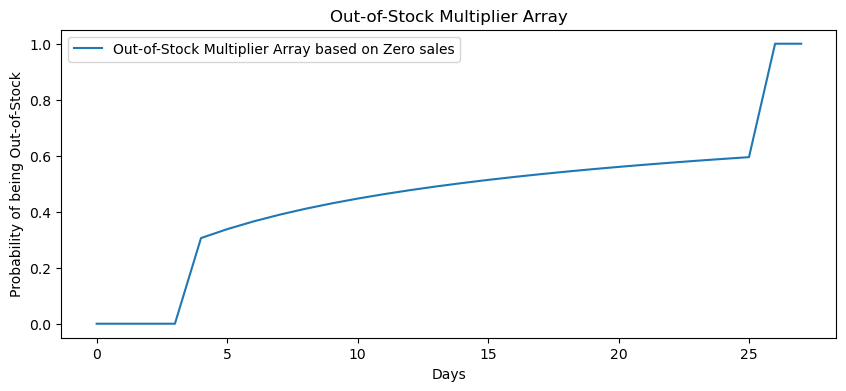

In [46]:
print('single_product_data shape', single_product_data['Sales'].shape)
# Prepare your sales data removing the last 28 days
a_without_last_28_days = single_product_data['Sales'].values.astype('int')[:-28]
print("Sales array shape 28 days: ", a_without_last_28_days.shape)
print("Non-zero entries: ", np.count_nonzero(a_without_last_28_days))

# Initialize the out_of_stock_zeroes class
oos_without_last_28_days = out_of_stock_zeroes(a_without_last_28_days)
mask = a_without_last_28_days != 0
n_zeroes_before = np.argmax(mask[::-1])
print("Consecutive zeros before last 28 days: ", n_zeroes_before)

out_of_stock_multiplier_array = oos_without_last_28_days.build_oos_prob_array(n_zeroes_before)

plt.figure(figsize=(10, 4))
plt.plot(out_of_stock_multiplier_array, label='Out-of-Stock Multiplier Array based on Zero sales')
plt.title("Out-of-Stock Multiplier Array")
plt.xlabel('Days')
plt.ylabel('Probability of being Out-of-Stock') 
plt.legend()
plt.show()



In [50]:

#oos_flags = oos_flags.tolist()
#out_of_stock_multiplier_array = out_of_stock_multiplier_array.tolist()

import json

# Prepare JSON data
output_json = {
    'forecasted_sales': forecast['yhat'][-4:].values.tolist(),
    'potential_oos_flags': future_df['Potential_OOS'].values.tolist(),
    'critical_stock_threshold': critical_stock_threshold,
    'historical_oos_flags': single_product_data['OOS_Flag'].values.tolist(),
    'mae': mae_prophet,
    "oos_flags": oos_flags,
    "out_of_stock_multiplier_array": out_of_stock_multiplier_array

}

# Convert to JSON
output_json_str = json.dumps(output_json, indent=4)




# To save it as a file
with open("oos_output.json", "w") as json_file:
    json.dump(output_json_str, json_file)



The alert_oos_flag output represents the weeks where the product "Tablet PRO Blauw" is flagged as likely being out-of-stock based on your sales data and the implemented OOS detection algorithm. These are the weeks where zero sales were observed for a duration long enough to trigger the out-of-stock flag.

What Does It Mean from a Customer Value Perspective?
Avoiding Disappointment: Knowing these risky weeks allows you to take preventive action, ensuring that customers find the product they want when they visit your e-commerce platform.

Enhanced Trust: If customers know that your platform maintains consistent stock levels, their trust in your platform increases, which can lead to higher customer retention.

Improved User Experience: Customers can have a seamless shopping experience without stumbling upon out-of-stock items, leading to increased overall satisfaction.

By acting on these OOS alerts, you're essentially making your e-commerce platform more reliable and user-friendly, which is crucial for customer loyalty and long-term success.


In the code for out-of-stock detection, "long enough" is determined through a series of calculations:

It counts the sequence of zeroes in sales, essentially capturing periods where no sales occurred.
It then calculates a divisor based on the logarithm of the mean sales when sales are greater than zero. This divisor essentially scales down the length of the zero sequence required to trigger an out-of-stock flag, especially when the mean sales are high.
Using this divisor, the code computes a minimum length for a sequence of zeroes to be considered an out-of-stock event. Any zero sequence longer than this minimum length triggers the out-of-stock flag.
So "long enough" is a dynamic value calculated based on the observed sales data, specifically designed to adapt to varying sales velocity.

A dynamic "long enough" criterion allows for adaptive and smarter inventory management

In [ ]:
#In green, actual sales
import seaborn as sns
sns.lineplot(x=np.arange(single_product.shape[0]),y=single_product,color='green')
#In red, out of stock flag. When 1 => out of stock day
sns.lineplot(x=np.arange(single_product.shape[0]),y=oos_flags,color='red')

In [ ]:
single_product

In [ ]:
# print first and last dates of df
print(df.ds.min())
print(df.ds.max())
print(future.ds.min())
print(future.ds.max())

In [ ]:
prophet_model.plot_components(forecast)

In [ ]:
# Python
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(prophet_model, forecast)

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


In [ ]:
# example 

df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=365)


In [ ]:
future.head()

In [ ]:
# print first and last dates of df
print(df.ds.min())
print(df.ds.max())
print(future.ds.min())
print(future.ds.max())

Sales Forecast as a Proxy for OOS for Each Product
Findings: By leveraging time-series forecasting methods, we estimate future sales for individual products. This helps us identify potential stock-outs before they happen.

Future Improvements: Integrate external factors like promotions and holidays for more accurate forecasting. Also, we aim to build separate models for high-performing and low-performing SKUs to fine-tune our predictions.

Customer Value: This enables us to be proactive rather than reactive, ensuring that popular items are always in stock. This leads to better customer satisfaction and increased sales

Stock Threshold
Current Approach: We're using the 75th percentile of historical sales as a "critical stock threshold." When forecasted sales exceed this level, we flag it as a potential out-of-stock scenario.

Future Improvements: Transition to a dynamic threshold that adapts to recent sales trends and seasonality. This will allow us to be more agile in our stock management.

Customer Value: By having a well-defined threshold, we minimize the risk of holding excess inventory while ensuring that we have adequate stock to meet demand. This translates to cost savings and better service levels.

OOS Alert System
Current Approach: The system generates alerts for upcoming weeks where a potential out-of-stock situation is predicted. These alerts are based on our sales forecast and stock threshold.

Future Improvements: Integrate these alerts into a real-time dashboard and tie them into our supply chain for automated reordering.

Customer Value: Real-time alerts mean we can act swiftly to prevent stock-outs, ensuring a seamless shopping experience for the customer. This builds trust and encourages repeat business.